In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import yfinance as yf

In [32]:
def annotate(ax, yPos, label=[], indexes=[]):
    for i in range(len(yPos)):
        x = i if len(indexes) == 0 else indexes[i]
        y = yPos[i]
        ax.annotate(label[i] if len(label) > 0 else np.round(y, decimals=2), xy=(x, y), xycoords='data',
                xytext=(-20, -40), textcoords='offset points',
                arrowprops=dict(facecolor='crimson', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom')

1. 阴线最低价，且前一天是成交量最大的阴线（收盘价低于开盘价）
    * 收盘价连续3天高于1的条件时提醒
2. 区间最低价，3天内收盘价高于最低价当天的最高价
3. 区间最低价之后的所有涨停板
4. 百个工作日的最高成交量

## 1.收盘价当天以及前3天都高于“压力位”时提醒
* 压力位条件：“成交量最大”的阴线(柱)次日的“日最低价”
* 阴线就是收盘价低于开盘价
* 

[*********************100%***********************]  1 of 1 completed


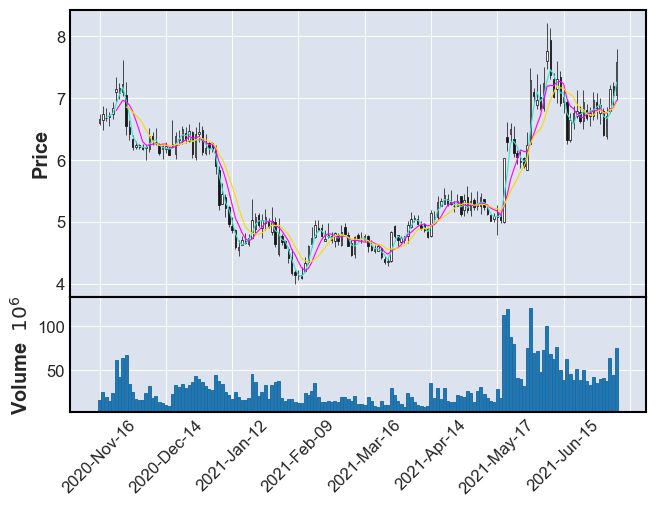

In [3]:
from pandas_datareader import data as pdr
# 将yahoo finance下载的数据格式设为Pandas Dataframe
yf.pdr_override()

# pthj = pdr.get_data_yahoo("603603.SS", start="2021-05-20", end="2021-10-22")
df = pdr.get_data_yahoo('300477.SZ', start="2020-11-16", end="2021-07-08")
mpf.plot(df,type='candle',mav=(3,6,9),volume=True)

阴线最高交易量             Open  High   Low  Close  Adj Close     Volume  Cloudy  signal_1
Date                                                                       
2021-05-20  6.37  6.62  6.15    6.3        6.3  119899764    True       NaN


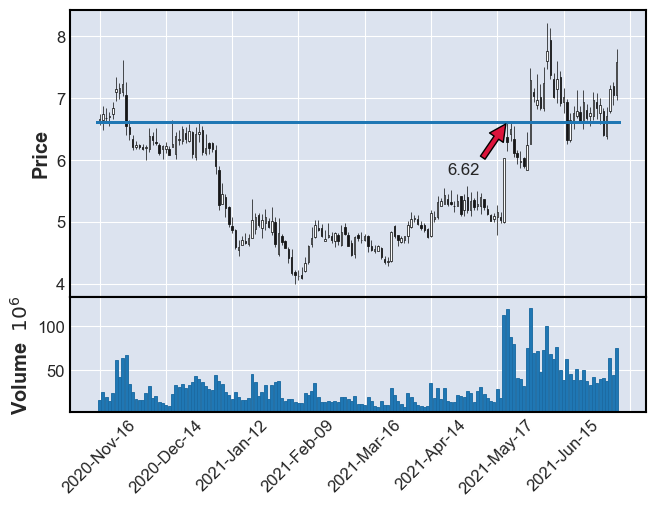

In [136]:
# 成交量最大的阴线
# Volume.max() & Close < Open
df['Cloudy'] = df['Close'] < df['Open']

def get_max(df, seriesName):
    return df[df[seriesName] == df[seriesName].max()]

max_cloudy = get_max(df[df['Cloudy'] == True], 'Volume')
print('阴线最高交易量',max_cloudy)

fig, axlist = mpf.plot(df, type='candle', volume=True, hlines=max_cloudy['High'].values[0] , returnfig=True)
indexlist = pd.Series(df.index)

annotate(axlist[0], 
    pd.Series(df['High'][df.index == max_cloudy.index.values[0]]),
    indexes=indexlist[indexlist == max_cloudy.index.values[0]].index)

压力点 Date
2021-05-21    6.31
Name: Low, dtype: float64


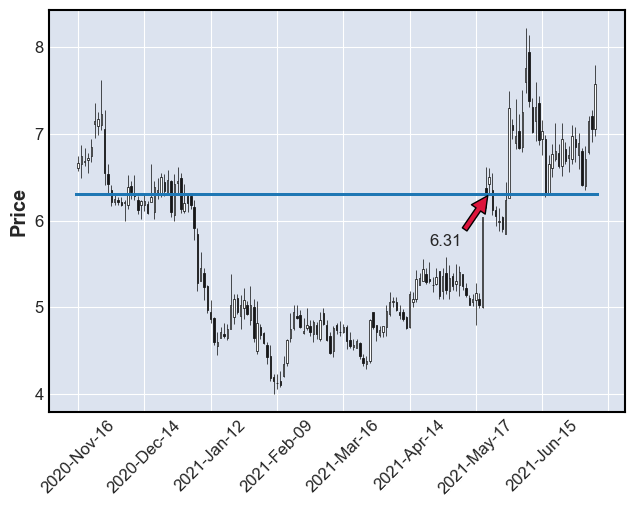

In [137]:
# 次日的“日最低价”
# max_cloudy.shift(1)['Low']
pressure_pt_1 = df[df.index > max_cloudy.index.values[0]].head(1)
print('压力点', pressure_pt_1['Low'])

fig, axlist = mpf.plot(df,type='candle', hlines=pressure_pt_1['Low'].values[0], returnfig=True)
indexlist = pd.Series(df.index)

annotate(axlist[0], pressure_pt_1['Low'], indexes=indexlist[indexlist == pressure_pt_1.index.values[0]].index)

提示：共 21 个信号


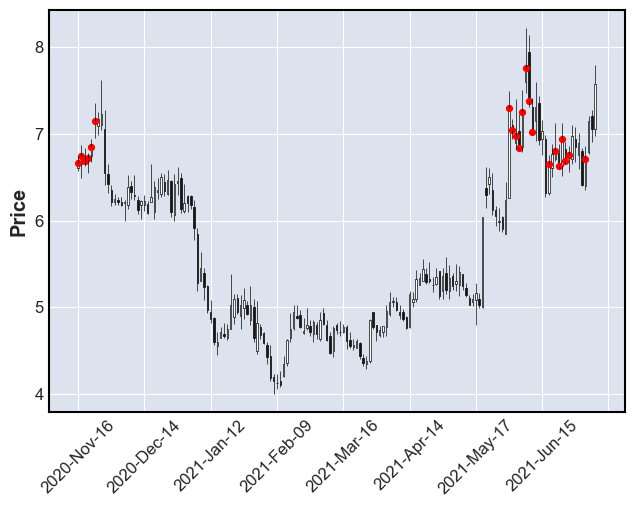

In [265]:
# 收盘价连续3天高于pressure_pt_1
# x.shift(1)['Close'] > pressure_pt_1['Close'] three times
df['signal_1'] = df['Close'][(df.shift(-1)['Close'] > pressure_pt_1['Close'].values[0])
    & (df.shift(-2)['Close'] > df['Close'].values[0])
    & (df.shift(-3)['Close'] > pressure_pt_1['Close'].values[0])
    & (df['Close'] > pressure_pt_1['Close'].values[0])]

# print('信号')
# print(df['signal_1'][df['signal_1'].isnull() == False].tail())
# print('\n\n信号前三天')
# print(df[df.index <= df['signal_1'].index].tail())

print('提示：共', df['signal_1'][df['signal_1'].isnull() == False].count(), '个信号')
if len(df['signal_1'][df['signal_1'].isnull() == False]) != 0:
    subplot = mpf.make_addplot(df['signal_1'], type='scatter', color='r')
    fig, axlist = mpf.plot(df,type='candle', addplot=[subplot], returnfig=True)
    # annotate(axlist[0], df['signal_1'], pd.Series(df.index.format()))
else:
    mpf.plot(df,type='candle')


## 2. 区间最低价，3天内收盘价高于最低价当天的最高价
* 支撑点：区间中的最低“收盘价”
* 第3日“收盘价”高于支撑点的“日最高价”

支撑点 Date
2021-02-10    4.1
Name: Close, dtype: float64


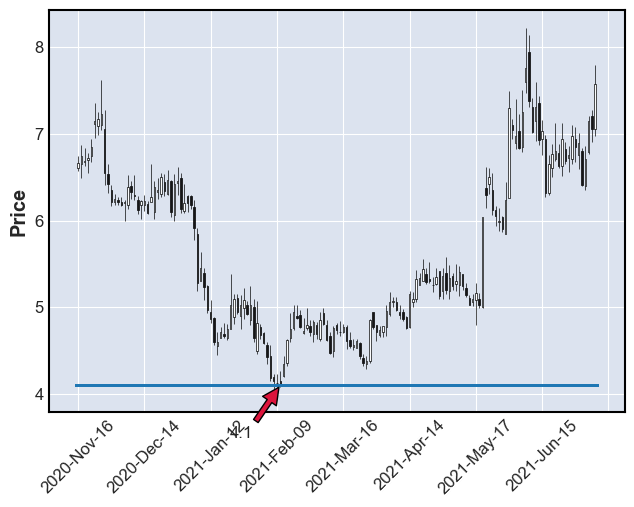

In [149]:
# 支撑点：区间中的最低“收盘价”
# Close.min()
support_pt_1 = df[df['Close'] == df['Close'].min()]
print('支撑点', support_pt_1['Close'])

fig, axlist = mpf.plot(df,type='candle', hlines=support_pt_1['Close'].values[0], returnfig=True)
indexlist = pd.Series(df.index)

annotate(axlist[0], support_pt_1['Close'], indexes=indexlist[indexlist == support_pt_1.index.values[0]].index)

提示：共 150 个信号


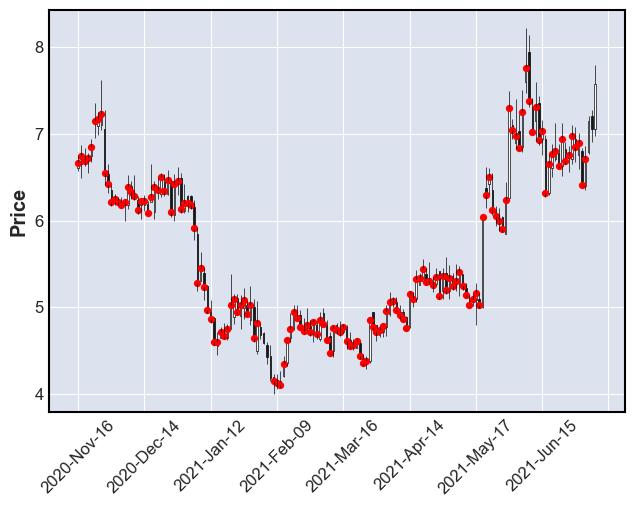

In [264]:
# 第3日“收盘价”高于支撑点的“日最高价”
# Close.shift(3) > support_pt_1
df['signal_2'] = df['Close'][df.shift(-3)['Close'] > support_pt_1['High'].values[0]]
# print('信号')
# print(df[df['signal_2'].isnull() == False])
# print('\n\n前三天')
# print(df[df.index >= df[df['signal_2'].isnull() == False].index.values[0]].head())
print('提示：共', df['signal_2'][df['signal_2'].isnull() == False].count(), '个信号')
if len(df['signal_2'][df['signal_2'].isnull() == False]) != 0:
    subplot = mpf.make_addplot(df['signal_2'], type='scatter', color='r')
    mpf.plot(df,type='candle',addplot=[subplot])
else:
    mpf.plot(df,type='candle')

## 3. 区间最低价之后的所有涨停板
* 支撑点：区间中的最低“收盘价”
* 涨停板：“收盘价”大于前日“收盘价”的109.9%
* 涨停板当天“成交量”大于等于前1日“成交量”的180%

支撑点 Date
2021-02-10    4.1
Name: Close, dtype: float64


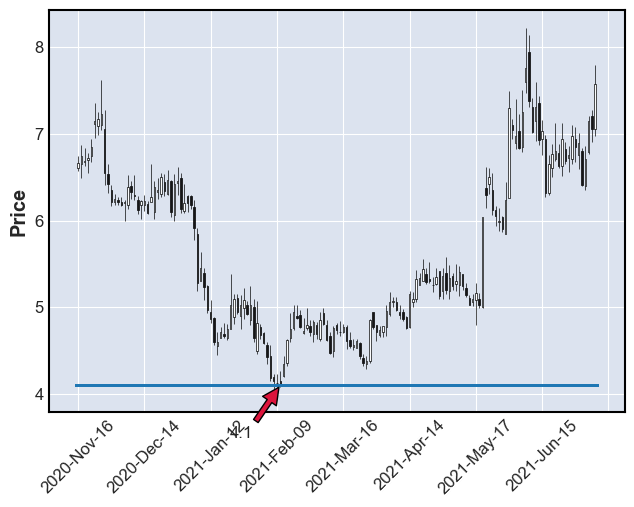

In [156]:
# 支撑点：区间中的最低“收盘价”
# Close.min()
support_pt_2 = df[df['Close'] == df['Close'].min()]
print('支撑点', support_pt_2['Close'])

fig, axlist = mpf.plot(df,type='candle', hlines=support_pt_2['Close'].values[0], returnfig=True)
indexlist = pd.Series(df.index)

annotate(axlist[0], support_pt_2['Close'], indexes=indexlist[indexlist == support_pt_1.index.values[0]].index)

涨停板


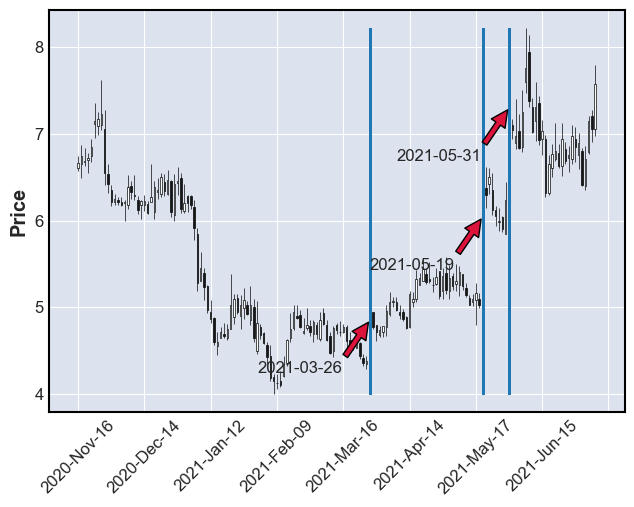

In [260]:
# 涨停板：“收盘价”大于前日“收盘价”的109.9%
# Close > Close.shift(-1) * 1.099
df['Grow Stop'] = df['Close'][df['Close'] > (df.shift(1)['Close'] * 1.099)]

# print('涨停板')
# print(df[df['Grow Stop'].isnull() == False])
# print('\n\n前1天')
# print(df[df.index <= df[df['Grow Stop'].isnull() == False].index[0]].tail(2))

print('涨停板')
lines = df.index[df['Grow Stop'].isnull() == False].tolist()
fig, axlist = mpf.plot(df,type='candle', vlines=lines, returnfig=True)
annotate(axlist[0], df['Grow Stop'], pd.Series(df.index.format()))

提示：共 2 个信号


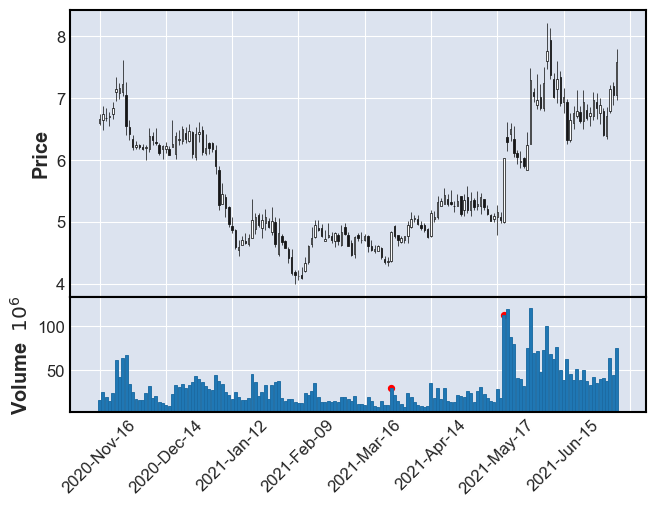

In [266]:
# 涨停板当天“成交量”大于等于前1日“成交量”的180%
# Grow Stop >= Volume.shift(1) * 1.8
df['signal_3'] = df['Volume'][(df['Grow Stop'].isnull() == False) & (df['Volume'] > (df.shift(1)['Volume'] * 1.8))]
# print('信号')
# print(df[df['signal_3'].isnull() == False])
# print('\n\n前1天')
# print(df[df.index <= df[df['signal_3'].isnull() == False].index.values[0]].tail(2))
print('提示：共', df['signal_3'][df['signal_3'].isnull() == False].count(), '个信号')
if len(df['signal_3'][df['signal_3'].isnull() == False]) != 0:
    subplot = [
        # mpf.make_addplot(df['signal_3'], type='scatter', color='r'),
    mpf.make_addplot(df['signal_3'], type='scatter', panel=1, color='r')]
    mpf.plot(df,type='candle', volume=True, addplot=subplot)
else:
    mpf.plot(df,type='candle', volume=True)

## 4. 百个工作日的最高成交量
* 最后一天的前100天中最高交易量

压力点 Date
2021-05-31    121024859
Name: Volume, dtype: int64


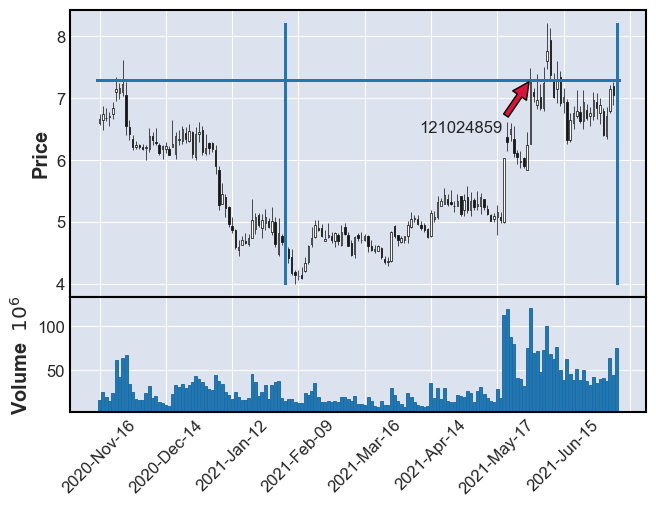

In [246]:
# 最后一天的前100天中最高交易量
# Volume.range(101).max()
indexlist = pd.Series(df.index)
date_range = df[(df.index > indexlist[len(indexlist.index) - 101])]
pressure_pt_2 = date_range[date_range['Volume'] == date_range['Volume'].max()]

print('压力点', pressure_pt_2['Volume'])

lines = [indexlist[len(indexlist.index) - 101], indexlist[len(indexlist.index) - 1]]
fig, axlist = mpf.plot(df,type='candle', volume=True, hlines=pressure_pt_2['Close'].values[0], vlines=lines, returnfig=True)
annotate(axlist[0], pressure_pt_2['Close'], pressure_pt_2['Volume'], indexes=indexlist[indexlist == pressure_pt_2.index.values[0]].index)